In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


#### Exploratory analysis of small subset of images

In [4]:
with open('test_subjects','rb') as f:
               images = pickle.load(f)

In [5]:
print('Number of records:', len(images))

Number of records: 11


In [6]:
print('Record names:', images.keys())

Record names: dict_keys(['OAS30001', 'OAS30002', 'OAS30004', 'OAS30005', 'OAS30006', 'OAS30007', 'OAS30008', 'OAS30019', 'OAS30022', 'OAS30024', 'OAS30027'])


In [7]:
print('First record keys:', images['OAS30001'].keys())

First record keys: dict_keys(['image', 'group'])


In [8]:
print('Shape of MRI:', images['OAS30001']['image'].shape)

Shape of MRI: (120, 160, 120)


In [9]:
print('Value of a center voxel:', images['OAS30001']['image'][60][80][60])

Value of a center voxel: 0.4679878048780488


Center (60th) 160x120 image of first MRI:


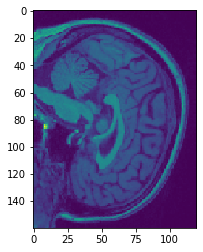

In [10]:
print('Center (60th) 160x120 image of first MRI:')
plt.imshow(images['OAS30001']['image'][60], interpolation='nearest')
plt.show()

All 160x120 images of first MRI:


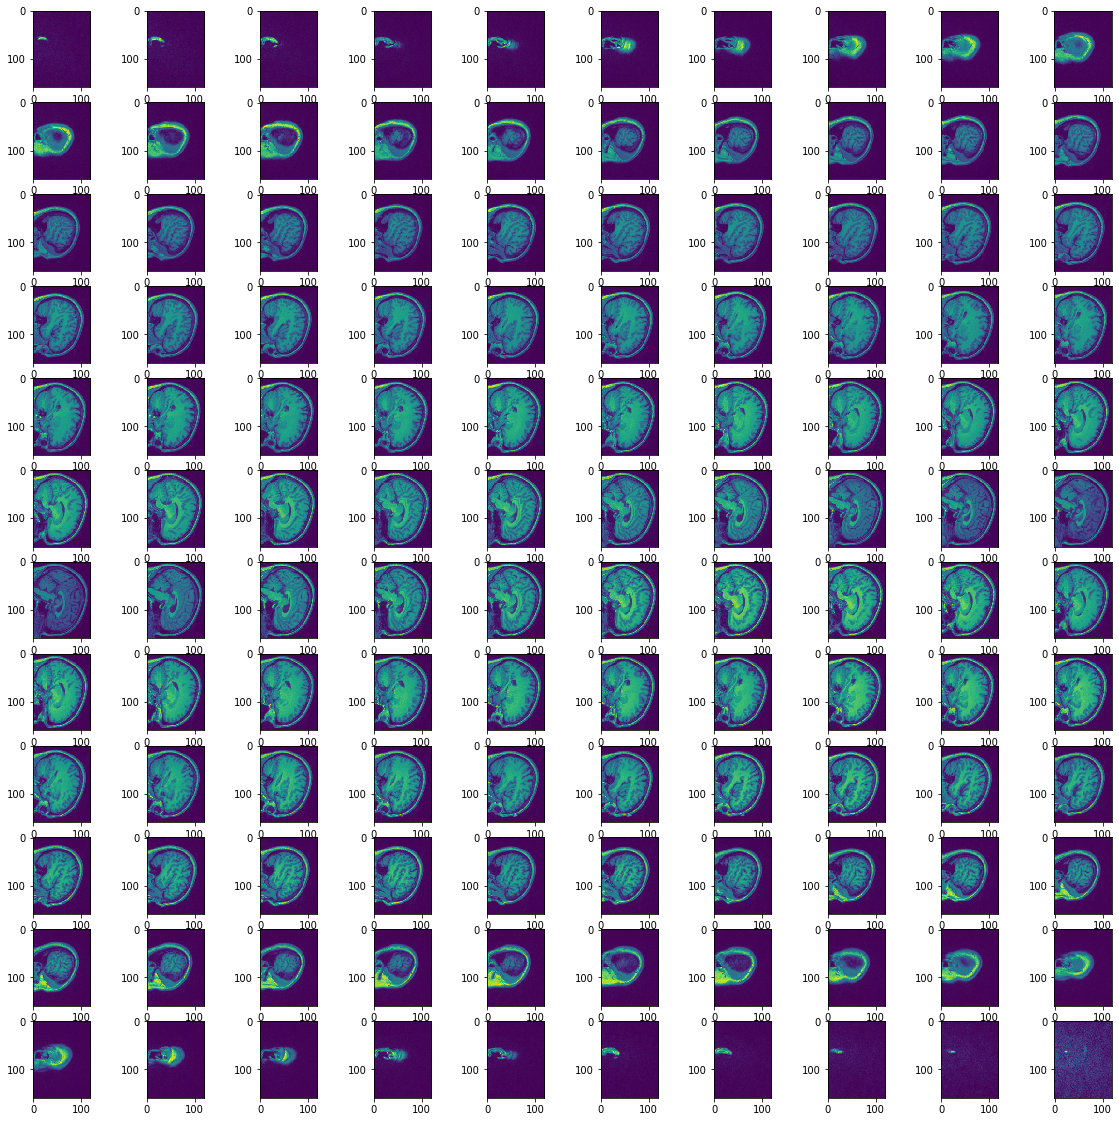

In [11]:
print('All 160x120 images of first MRI:')
fig, axes = plt.subplots(12,10, figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ax.imshow(images['OAS30001']['image'][i])

##### --- Start adaptation from Arezoo's notebook ---

#### Subject IDs

In [12]:
im_name_list = []

for x1 in images:
    im_name_list.append(x1)
im_name_list

# im_name_list : list of image names

['OAS30001',
 'OAS30002',
 'OAS30004',
 'OAS30005',
 'OAS30006',
 'OAS30007',
 'OAS30008',
 'OAS30019',
 'OAS30022',
 'OAS30024',
 'OAS30027']

#### Making training and test sets

In [13]:
pixels = np.zeros((1, 120, 160, 120))
for name in im_name_list:
    pixels = np.append(pixels ,np.reshape(images[name]['image'], (1, 120, 160, 120)), axis=0)

# print(pixels.shape)
# pixels : initial zeroes row and 4D representation of images
# input_ims : 4D representation of images

input_ims = pixels[1:12, :, :, :] 
input_ims.shape

(11, 120, 160, 120)

In [14]:
x_train = input_ims[0:9, :, :, :] # x_train : first 9 records
x_train.shape

(9, 120, 160, 120)

In [15]:
x_test = input_ims[9:11, :, :, :] # x_test : last 2 records
x_test.shape

(2, 120, 160, 120)

In [16]:
x_test = np.reshape(x_test, (2, 120, 160, 120, 1))

#### Making target values

In [17]:
y_train = [images[key]['group'] for key in images.keys()]
y_test = y_train[-2:] # y_test : last 2 records
y_test

['AD', 'AD']

In [18]:
y_train = y_train[:9] # y_train : first 9 records
y_train

['CN', 'CN', 'CN', 'CN', 'CN', 'CN', 'CN', 'AD', 'AD']

In [19]:
def convert_numeric(x):
    if x == "AD":
        return 1
    elif x == "CN":
        return 0
    else:
        return x 


In [20]:
y_train = list(map(convert_numeric, y_train))
y_train

[0, 0, 0, 0, 0, 0, 0, 1, 1]

In [21]:
y_test = list(map(convert_numeric, y_test))
y_test

[1, 1]

In [22]:
len(input_ims)

11

In [23]:
#looking into first image
first_im = images['OAS30001']
first = first_im['image']
first.shape

(120, 160, 120)

In [24]:
first_modified = np.reshape(first, (120, 160, 120 , 1))

In [25]:
first_modified.shape

(120, 160, 120, 1)

In [26]:
x_train = np.reshape(x_train, (9, 120, 160, 120, 1) )
x_test = np.reshape(x_test, (2, 120, 160, 120, 1) ) 

#### Building Encoder

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, MaxPool3D, Dropout, \
    Flatten, Conv3DTranspose, UpSampling3D, Reshape
from tensorflow.keras.layers import Input


In [28]:
input_img = Input(shape=(120, 160, 120 , 1), name='Input')

print('\ninput shape:', input_img.shape)

x = Conv3D(10, (3,3,3), activation='relu', padding='same', name='Convolution_1')(input_img)
x = MaxPool3D((2,2,2), name='MaxPooling_1')(x)
x = Dropout(0.8, name='DropOut_1')(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same', name='Convolution_2')(x)
x = MaxPool3D((2,2,2), name='MaxPooling_2')(x)
x = Dropout(0.8, name='DropOut_2')(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same', name='Convolution_3')(x)
x = MaxPool3D((2,2,2), name='MaxPooling_3')(x)
x = Dropout(0.8, name='DropOut_3')(x)

conv_shape = K.int_shape(x)

print('shape after convolutions:', conv_shape)

x = Flatten(name='Flatten')(x)

x = Dense(32, activation='selu', name='SELU_1')(x)
x = Dense(16, activation='selu', name='SELU_2')(x)

encoded = Dense(2, name='Encoded')(x)

encoded_shape = K.int_shape(encoded)

print('final encoded shape:', encoded_shape, '\n')

encoder = Model(input_img, encoded, name='CAE_encoder')
encoder.summary()



input shape: (None, 120, 160, 120, 1)
shape after convolutions: (None, 15, 20, 15, 10)
final encoded shape: (None, 2) 

Model: "CAE_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 120, 160, 120, 1) 0         
_________________________________________________________________
Convolution_1 (Conv3D)       (None, 120, 160, 120, 10) 280       
_________________________________________________________________
MaxPooling_1 (MaxPooling3D)  (None, 60, 80, 60, 10)    0         
_________________________________________________________________
DropOut_1 (Dropout)          (None, 60, 80, 60, 10)    0         
_________________________________________________________________
Convolution_2 (Conv3D)       (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
MaxPooling_2 (MaxPooling3D)  (None, 30, 40, 30, 10)    0         


##### CAE Encoder layers

Input

    120 x 160 x 120 x 1

Convolutional layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    120 x 160 x 120 x 10

Maxpooling downsample (2x2x2 kernel)

    60 x 80 x 60 x 10

Dropout (80% of nodes set to 0)

    60 x 80 x 60 x 10

Convolutional layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    60 x 80 x 60 x 10

Maxpooling downsample (2x2x2 kernel)

    30 x 40 x 30 x 10

Dropout (80% of nodes set to 0)

    30 x 40 x 30 x 10

Convolutional layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    30 x 40 x 30 x 10

Maxpooling downsample (2x2x2 kernel)

    15 x 20 x 15 x 10

Dropout (80% of nodes set to 0)

    15 x 20 x 15 x 10

Flatten

    45000

Dense layer (32 channels, SELU activation)

    32

Dense layer (16 channels, SELU activation)

    16

Dense layer (2 possible outputs)

    2


#### Building Decoder

In [29]:
encoded_input = Input(shape=(encoded_shape[1],), name='Encoded')

print('\ninput shape:', encoded_input.shape)

x = Dense(16, activation='selu', name='SELU_2')(encoded_input)
x = Dense(32, activation='selu', name='SELU_1')(x)
x = Dense(np.prod(conv_shape[1:]), name='Product')(x)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3], conv_shape[4]), name='Reshape')(x)

print('shape after reshape:', K.int_shape(x))

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same', name='Convolution_3')(x)
x = UpSampling3D((2,2,2), name='UpSampling_3')(x)
x = Dropout(0.8, name='DropOut_3')(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same', name='Convolution_2')(x)
x = UpSampling3D((2,2,2), name='UpSampling_2')(x)
x = Dropout(0.8, name='DropOut_2')(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same', name='Convolution_1')(x)
x = UpSampling3D((2,2,2), name='UpSampling_1')(x)
x = Dropout(0.8, name='DropOut_1')(x)

# decoded = Dense(1, activation='sigmoid', name='Output')(x)
decoded = Conv3DTranspose(1, (3,3,3), activation='sigmoid', padding='same', name='Output')(x)

print('final decoded shape:', K.int_shape(decoded), '\n')

decoder = Model(encoded_input, decoded, name='CAE_decoder')
decoder.summary()



input shape: (None, 2)
shape after reshape: (None, 15, 20, 15, 10)
final decoded shape: (None, 120, 160, 120, 1) 

Model: "CAE_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoded (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
SELU_2 (Dense)               (None, 16)                48        
_________________________________________________________________
SELU_1 (Dense)               (None, 32)                544       
_________________________________________________________________
Product (Dense)              (None, 45000)             1485000   
_________________________________________________________________
Reshape (Reshape)            (None, 15, 20, 15, 10)    0         
_________________________________________________________________
Convolution_3 (Conv3DTranspo (None, 15, 20, 15, 10)    2710      
_____

##### CAE Decoder layers

Input

    2

Dense layer (16 channels, SELU activation)

    16

Dense layer (32 channels, SELU activation)

    32

Dense layer (product of encoded_shape dimensions 15x20x15x10)

    45000

Reshape to encoded_shape dimensions

    15 x 20 x 15 x 10

Convolutional transpose layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    15 x 20 x 15 x 10

Upsampling (2x2x2 kernel)

    30 x 40 x 30 x 10

Dropout (80% of nodes set to 0)

    30x 40 x 30 x 10

Convolutional transpose layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    30 x 40 x 30 x 10

Upsampling (2x2x2 kernel)

    60 x 80 x 60 x 10

Dropout (80% of nodes set to 0)

    60 x 80 x 60 x 10

Convolutional transpose layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    60 x 80 x 60 x 10

Upsampling (2x2x2 kernel)

    120 x 160 x 120 x 10

Dropout (80% of nodes set to 0)

    120 x 160 x 120 x 10

Convolutional transpose layer (1 channel, 3x3x3 kernel, sigmoid activation, padding)

    120 x 160 x 120 x 1


#### Building Autoencoder

In [30]:
autoencoder = Model(input_img, decoder(encoder(input_img)), name='CAE_autoencoder')
autoencoder.summary()

Model: "CAE_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 120, 160, 120, 1) 0         
_________________________________________________________________
CAE_encoder (Model)          (None, 2)                 1446294   
_________________________________________________________________
CAE_decoder (Model)          (None, 120, 160, 120, 1)  1493993   
Total params: 2,940,287
Trainable params: 2,940,287
Non-trainable params: 0
_________________________________________________________________


In [38]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

hist = autoencoder.fit(x_train, x_train, epochs=2, verbose=1, \
                       validation_data=(x_test, x_test)) # epochs=200

Train on 9 samples, validate on 2 samples
Epoch 1/2
9/9 [==============================] - 75s 8s/sample - loss: 0.6983 - val_loss: 0.6916
Epoch 2/2
9/9 [==============================] - 68s 8s/sample - loss: 0.6970 - val_loss: 0.6905


##### --- End adaption from Arezoo's notebook ---

### ICAE Inception Model

#### Building Encoder

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, MaxPool3D, Dropout, Flatten, \
    Conv3DTranspose, UpSampling3D, Reshape
from tensorflow.keras.layers import Input

from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l1_l2


In [33]:
def inception_module(input, filter_operation):
    """
    filter_operation is a list of inception operations for:
        1x1x1 kernel, 
        1x1x1 then 3x3x3 kernels, 
        1x1x1 then 3x3x3 then 3x3x3 kernels, 
        and 3x3x3 maxpooling then 1x1x1 kernels, 
            respectively.
    """
    
    # According to Nature paper (Oh et. al.), l1 and l2 values of 10e-4 performed the best 
    #   from experimentation with 0.01, 0.001, 0.0001, 0.00001 values.
    l1_value = 10e-4
    l2_value = 10e-4

    # Branch A
    branch_1x1x1 = Conv3D(filter_operation[0], kernel_size=(1, 1, 1), activation='relu', \
                          padding='same', kernel_regularizer=l1_l2(l1_value, l2_value), \
                          name='Branch_A_1x1x1')(input)

    # Branch B
    branch_3x3x3_initial = Conv3D(filter_operation[1], kernel_size=(1, 1, 1), activation='relu', \
                                  padding='same', kernel_regularizer=l1_l2(l1_value, l2_value), \
                                  name='Branch_B_1x1x1')(input)
    branch_3x3x3 = Conv3D(filter_operation[1], kernel_size=(3, 3, 3), activation='relu', \
                          padding='same', kernel_regularizer=l1_l2(l1_value, l2_value), \
                          name='Branch_B_3x3x3')(branch_3x3x3_initial)

    # Branch C
    branch_double_3x3x3_initial = Conv3D(filter_operation[2], kernel_size=(1, 1, 1), \
                                         activation='relu', padding='same', \
                                         kernel_regularizer=l1_l2(l1_value, l2_value), \
                                         name='Branch_C_1x1x1')(input)
    branch_double_3x3x3_middle = Conv3D(filter_operation[2], kernel_size=(3, 3, 3), \
                                        activation='relu', padding='same', \
                                        kernel_regularizer=l1_l2(l1_value, l2_value), \
                                        name='Branch_C_1st_3x3x3')(branch_double_3x3x3_initial)
    branch_double_3x3x3 = Conv3D(filter_operation[2], kernel_size=(3, 3, 3), activation='relu', \
                                 padding='same', kernel_regularizer=l1_l2(l1_value, l2_value), \
                                 name='Branch_C_2nd_3x3x3')(branch_double_3x3x3_middle)

    # Branch D
    branch_maxpool_3x3x3_initial = MaxPool3D(pool_size=(3, 3, 3), strides=(1, 1, 1), \
                                             padding='same', name='Branch_D_3x3x3_maxpool')(input)
    branch_maxpool_3x3x3 = Conv3D(filter_operation[3], kernel_size=(1, 1, 1), activation='relu', \
                                  padding='same', kernel_regularizer=l1_l2(l1_value, l2_value), \
                                  name='Branch_D_1x1x1')(branch_maxpool_3x3x3_initial)
    
    # Merge branches
    modules = [branch_1x1x1, branch_3x3x3, branch_double_3x3x3, branch_maxpool_3x3x3]
    merged_module = concatenate(modules, name='Inception_Merged') # axis=-1
    
    return merged_module
    

In [34]:
# ICAE model

input_img = Input(shape= (120, 160, 120 , 1), name='Input')

print('\ninput shape:', input_img.shape)

x = Conv3D(10, (3,3,3), activation='relu', padding='same', name='Convolution_1')(input_img)
x = MaxPool3D((2,2,2), name='MaxPooling_1')(x)
# x = Dropout(0.8, name='DropOut_1')(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same', name='Convolution_2')(x)
x = MaxPool3D((2,2,2), name='MaxPooling_2')(x)
x = Dropout(0.8, name='DropOut_2')(x)

filter_operations = [40, 40, 40, 40]

x = inception_module(x, filter_operations)
x = MaxPool3D((2,2,2), name='Inception_MaxPooling')(x)
# x = Dropout(0.8, name='DropOut_3')(x)

print('shape after inception:', K.int_shape(x))

encoded = Dense(2, activation='sigmoid', name='Encoded')(x)

encoder = Model(input_img, encoded, name='ICAE_encoder')

encoded_shape = K.int_shape(encoded)
print('final encoded shape:', encoded_shape, '\n')

encoder.summary(positions=[.35, .64, .71, 1.]) # adjusts print settings to minimize truncation



input shape: (None, 120, 160, 120, 1)
shape after inception: (None, 15, 20, 15, 160)
final encoded shape: (None, 15, 20, 15, 2) 

Model: "ICAE_encoder"
__________________________________________________________________________________________________
Layer (type)                      Output Shape                Param  Connected to                 
Input (InputLayer)                [(None, 120, 160, 120, 1)]  0                                   
__________________________________________________________________________________________________
Convolution_1 (Conv3D)            (None, 120, 160, 120, 10)   280    Input[0][0]                  
__________________________________________________________________________________________________
MaxPooling_1 (MaxPooling3D)       (None, 60, 80, 60, 10)      0      Convolution_1[0][0]          
__________________________________________________________________________________________________
Convolution_2 (Conv3D)            (None, 60, 80, 60, 10

##### ICAE Encoder layers

Input

    120 x 160 x 120 x 1

Convolutional layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    120 x 160 x 120 x 10

Maxpooling downsample (2x2x2 kernel)

    60 x 80 x 60 x 10

Convolutional layer (10 channels, 3x3x3 kernel, ReLU activation, padding)

    60 x 80 x 60 x 10

Maxpooling downsample (2x2x2 kernel)

    30 x 40 x 30 x 10

Dropout (80% of nodes set to 0)

    30 x 40 x 30 x 10

Inception branched layers

    A: 30 x 40 x 30 x 40

    B: 30 x 40 x 30 x 40  ->  30 x 40 x 30 x 40

    C: 30 x 40 x 30 x 40  ->  30 x 40 x 30 x 40  ->  30 x 40 x 30 x 40

    D: 30 x 40 x 30 x 10  ->  30 x 40 x 30 x 40

Inception merged layer

    30 x 40 x 30 x 160

Maxpooling downsample (2x2x2 kernel)

    15 x 20 x 15 x 160

Dense layer (2 possible outputs, SoftMax activation)

    15 x 20 x 15 x 2


#### Building Decoder

In [35]:
encoded_input= Input(shape=(encoded_shape[1],encoded_shape[2], \
                            encoded_shape[3], encoded_shape[4],), name='Input')

print('\ninput shape:', encoded_input.shape)

x = Dense(160, activation='selu', name='SELU')(encoded_input)

filter_operations = [40, 40, 40, 40]
# filter_operations = [10, 10, 10, 10]

x = inception_module(x, filter_operations)

print('shape after inception:', K.int_shape(x))

x = UpSampling3D((2,2,2), name='Inception_Upsampling')(x)
# x = Dropout(0.8, name='DropOut_3')(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same', name='Convolution_2')(x)
x = UpSampling3D((2,2,2), name='Upsampling_2')(x)
x = Dropout(0.8, name='DropOut_2')(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same', name='Convolution_1')(x)
x = UpSampling3D((2,2,2), name='Upsampling_1')(x)
# x = Dropout(0.8, name='DropOut_1')(x)

# decoded = Dense(1, activation='sigmoid', name='Output')(x)
decoded = Conv3DTranspose(1, (3,3,3), activation='sigmoid', padding='same', name='Output')(x)

print('final decoded shape:', K.int_shape(decoded), '\n')

decoder = Model(encoded_input, decoded, name='ICAE_decoder')
decoder.summary(positions=[.35, .64, .71, 1.])



input shape: (None, 15, 20, 15, 2)
shape after inception: (None, 15, 20, 15, 160)
final decoded shape: (None, 120, 160, 120, 1) 

Model: "ICAE_decoder"
__________________________________________________________________________________________________
Layer (type)                      Output Shape                Param  Connected to                 
Input (InputLayer)                [(None, 15, 20, 15, 2)]     0                                   
__________________________________________________________________________________________________
SELU (Dense)                      (None, 15, 20, 15, 160)     480    Input[0][0]                  
__________________________________________________________________________________________________
Branch_C_1x1x1 (Conv3D)           (None, 15, 20, 15, 40)      6440   SELU[0][0]                   
__________________________________________________________________________________________________
Branch_B_1x1x1 (Conv3D)           (None, 15, 20, 15, 40

#### Building Autoencoder

In [36]:
ICAE_autoencoder = Model(input_img, decoder(encoder(input_img)), name='ICAE_autoencoder')
ICAE_autoencoder.summary()

Model: "ICAE_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 120, 160, 120, 1) 0         
_________________________________________________________________
ICAE_encoder (Model)         (None, 15, 20, 15, 2)     134792    
_________________________________________________________________
ICAE_decoder (Model)         (None, 120, 160, 120, 1)  202151    
Total params: 336,943
Trainable params: 336,943
Non-trainable params: 0
_________________________________________________________________


In [39]:
ICAE_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

ICAE_hist = ICAE_autoencoder.fit(x_train, x_train, epochs=2, verbose=1, \
                                 validation_data=(x_test, x_test)) # epochs=200

Train on 9 samples, validate on 2 samples
Epoch 1/2
9/9 [==============================] - 103s 11s/sample - loss: 10.6043 - val_loss: 10.2496
Epoch 2/2
9/9 [==============================] - 94s 10s/sample - loss: 10.2545 - val_loss: 9.9024
